- FPN (Feature Pyramid Network), by Facebook AI Research (FAIR), Cornell University and Cornell Tech, is reviewed. By introducing a clean and simple framework for building feature pyramids inside the convolutional neural network (CNN), significant improvements are shown over several strong baselines and competition winners such as G-RMI, MultiPathNet and ION. And FPN has higher AR for segment proposals compared with DeepMask, SharpMask and InstanceFCN.
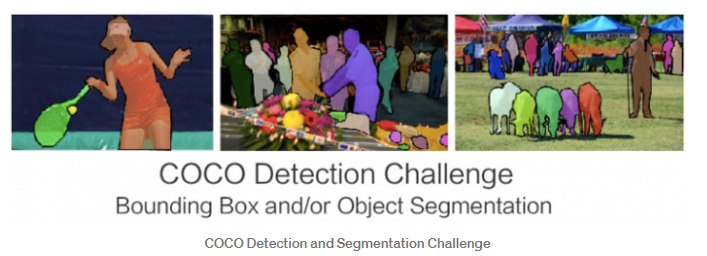

#  Various Architecture in Literature  
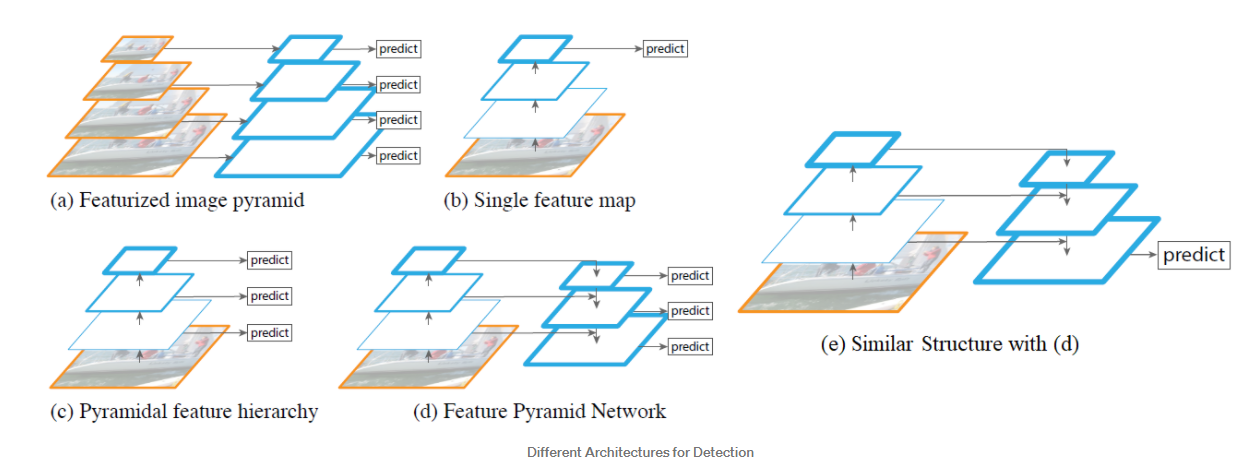

**(a) Featurized image pyramid** 
- It is heavily used in the era of hand-engineered features.

**(b) Single feature map** 
- It is a standard ConvNet solution on a single input image which has the prediction at the end of network.

**(c) Pyramidal Feature Hierarchy** 
- At each layer, prediction is made just like SSD. It reuses the multi-scale feature maps from different layers computed in the forward pass and thus come free of cost.
- However, it misses the opportunity to reuse the higher-resolution maps of the feature hierarchy, consequently misses the detection for small objects.

**(d) Feature Pyramid Network**
- It combines low-resolution, semantically strong features with high-resolution, semantically weak features via a top-down pathway and lateral connections.
- This feature pyramid that has rich semantics at all levels and is built quickly from a single input image scale, thereby without sacrificing representational power, speed, or memory. Some concurrent works like DSSD also use this approach.

**(e) Similar Architecture**  
- Some recent research adopted the similar top-down and skip connections such as TDM, SharpMask, RED-Net, U-Net, which were quite popular at that moment, but only predict at the last stage.

# Feature Pyramid Network (FPN)
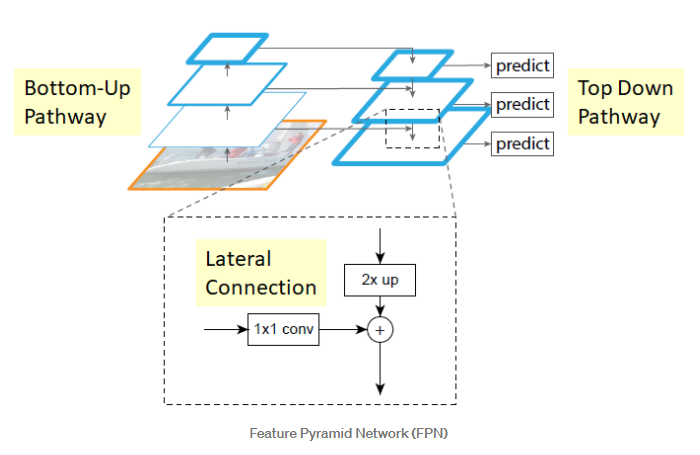
## Bottom-Up Pathway
- The bottom-up pathway is the feedforward computation of the backbone ConvNet. It is defined that one pyramid level is for each stage. The output of the last layer of each stage will be used as the reference set of feature maps for enriching the top-down pathway by lateral connection.
## Top-Down Pathway and Lateral Connection
- The higher resolution features is upsampled spatially coarser, but semantically stronger, feature maps from higher pyramid levels. More specifically, the spatial resolution is upsampled by a factor of 2 using the nearest neighbor for simplicity.
- Each lateral connection merges feature maps of the same spatial size from the bottom-up pathway and the top-down pathway.
- Specifically, the feature maps from bottom-up pathway undergoes 1×1 convolutions to reduce the channel dimensions.
- And the feature maps from the bottom-up pathway and the top-down pathway are merged by element-wise addition.
## Prediction
- Finally, a 3×3 convolution is appended on each merged map to generate the final feature map, which is to reduce the aliasing effect of upsampling. This final set of feature maps is called {P2, P3, P4, P5}, corresponding to {C2, C3, C4, C5} that are respectively of the same spatial sizes.
- Because all levels of the pyramid use shared classifiers/regressors as in a traditional featurized image pyramid, the feature dimension at output d is fixed with d = 256. Thus, all extra convolutional layers have 256-channel outputs.

# FPN for Region Proposal Network (RPN)
- In the original RPN design in Faster R-CNN, a small subnetwork is evaluated on dense 3×3 sliding windows, on top of a single-scale convolutional feature map, performing object/non-object binary classification and bounding box regression.
- This is realized by a 3×3 convolutional layer followed by two sibling 1×1 convolutions for object/non-object classification and regression, which we refer to as a network head.
- Here, the single-scale feature map in RPN is replaced by FPN. Thus, it is not necessary to have multi-scale anchor boxes on a specific level.
- A single scale to each level is assigned to each level. Formally, It is defined the anchors to have areas of {32², 64², 128², 256², 512²} pixels on {P2, P3, P4, P5, P6} respectively.
- And at each level, multiple aspect ratios of {1:2, 1:1, 2:1} are used.
- An anchor is assigned a positive labels if it has the highest IoU for a given ground-truth box or an IoU over 0.7 with any ground-truth box, and a negative label if it has IoU lower than 0.3 for all ground-truth boxes.
- The parameters of the heads are shared across all feature pyramid levels.


#  FPN for Detection Network
- In original detection network in Faster R-CNN, a single-scale feature map is used.

- Here, to detect the object, ROIs of different scales are needed to be assigned to the pyramid levels.

- Formally, an ROI of width w and height h (on the input image to the network) is assigned to the level Pk of our feature pyramid by:
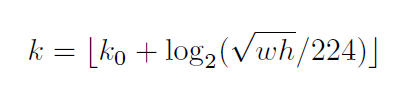

- 224 is used since it is the canonical ImageNet pre-training size.
- And Faster R-CNN uses C4 as the single-scale feature map, k0 is set to 4.
- Thus, if 224×224, k = 4. We use P4.
- If 112×112, k = 3. It is mapped to finer-resolution level of P3.
- predictor heads (in Fast R-CNN the heads are class-specific classifiers and bounding box regressors) are attached to all RoIs of all levels. Again, the heads all share parameters, regardless of their levels.

- RoI pooling is adopted to extract 7×7 features, and attach two hidden 1,024-d fully-connected (fc) layers before the final classification and bounding box regression layers.

#  Ablation Experiments
##  Ablation Experiments on RPN 
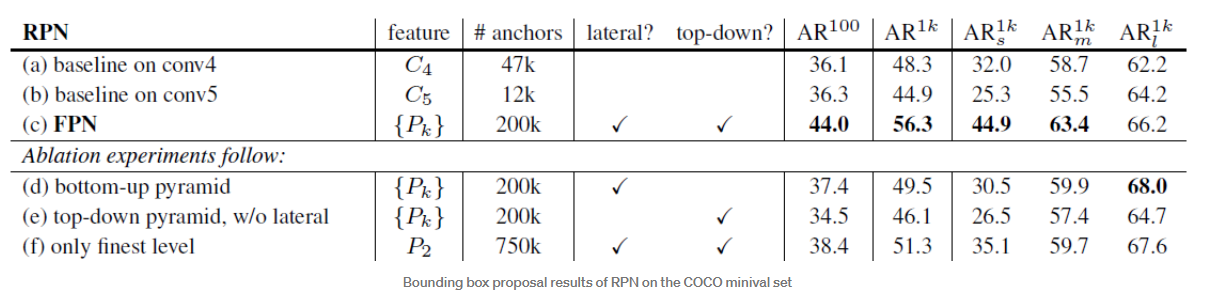
### Comparisons with baselines
- (b) Using conv5 shows no advantages over (a) using conv4: A single higher-level feature map is not enough because there is a trade-off between coarser resolutions and stronger semantics.   

- (c) Placing FPN in RPN improves AR1k to 56.3, which is 8.0 points increase over the single-scale RPN baseline.
- In addition, the performance on small objects (AR1ks) is boosted by a large margin of 12.9 points.
- Thus, FPN on RPN is robustness to object scale variation.

### Top-Down Enrichment
- (d) is the FPN but without the top-down pathway. With this modification, the 1×1 lateral connections followed by 3×3 convolutions are attached to the bottom-up pyramid. It simulates the effect of reusing the pyramidal feature hierarchy. (i.e. the architecture of (c) in the first figure)
- The results are just inferior compared with FPN (c).
- It is conjectured that this is because there are large semantic gaps between different levels on the bottom-up pyramid (b), especially for very deep ResNets.
- A variant of (d) without sharing the parameters of the heads is also evaluated, but observed similarly degraded performance.
### Lateral Connections
- (e), a top-down feature pyramid without the 1×1 lateral connections. This top-down pyramid has strong semantic features and fine resolutions.
- It is argued that the locations of these features are not precise, because these maps have been downsampled and upsampled several times.
- FPN in (c) has an AR1k score 10 points higher than (e).
### Pyramid Representations
- (f), the head is attached to the highest-resolution, strongly semantic feature maps of P2. All anchors are assigned to the P2 feature map.
- This variant is better than the baseline but inferior to FPN.

## Ablation Experiments on Detection Network
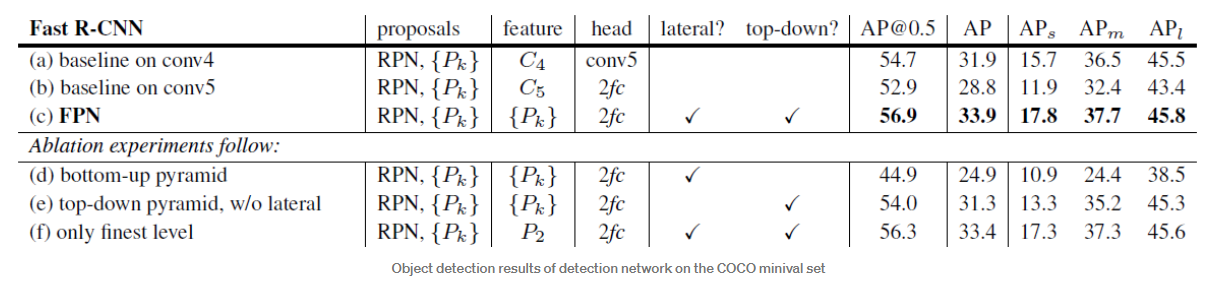
- Ablations are conducted on a fixed set of proposals. The proposals are frozen as computed by FPN for RPN. Features between the detection network and RPN are not shared.

- FPN (c) improves AP by 2.0 and small object AP by 2.1 against the baseline on conv4 (a).

- Removing top-down connections (d) or removing lateral connections (e) leads to inferior results.

- Removing top-down connections (d) significantly degrades the accuracy. It suffers from using the low-level features at the high-resolution maps.

- Using the single finest scale feature map of P2 (e), Its result (33.4 AP) is marginally worse than FPN (c).

## Consistent Backbone Architecture for detection network and RPN
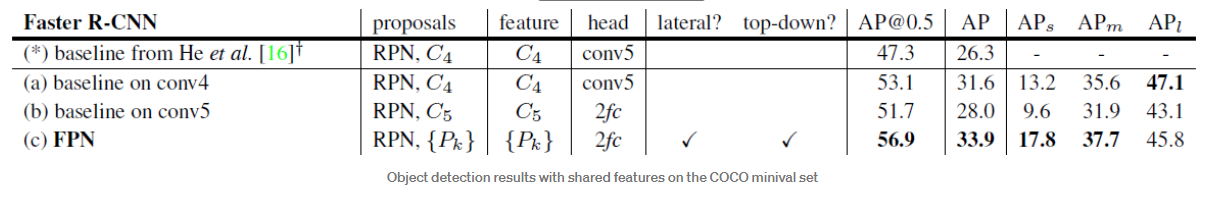
- All uses the consistent backbone architectures for RPN and detection network. (But not yet sharing features)

- FPN (c) is better than this strong baseline by 2.3 points AP and 3.8 points AP@0.5. (The baseline in (a) and (b) is better than the baseline shown in ResNet.)

## Shared Features for detection network and RPN
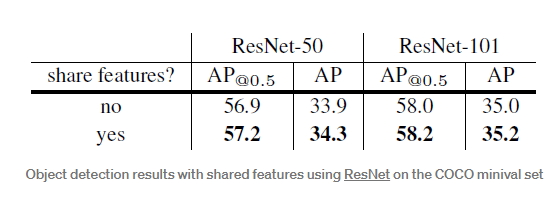
- Sharing features improves accuracy by a small margin. Feature sharing also reduces the testing time. FPN has inference time of 0.148 seconds per image on a single NVIDIA M40 GPU for ResNet-50, and 0.172 seconds for ResNet-101.

# Comparison with State-of-the-art Approaches
## COCO Detection Challenge
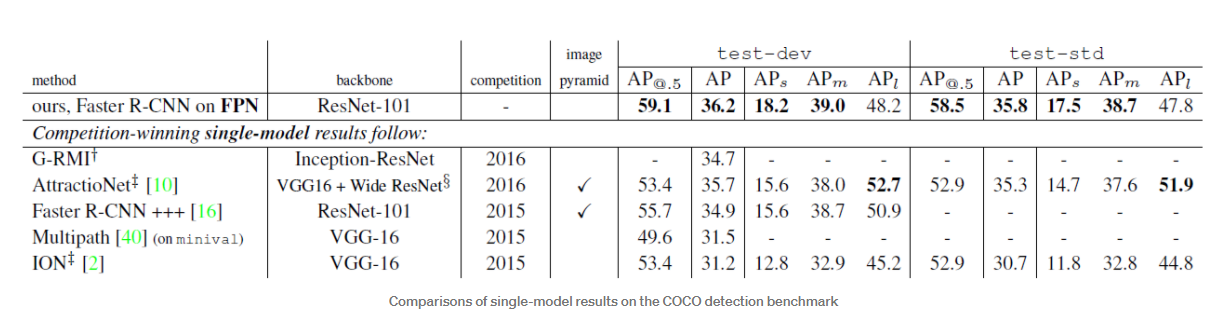
- On the test-dev set, our method increases over the existing best results by 0.5 points of AP (36.2 vs. 35.7) and 3.4 points of AP@0.5 (59.1 vs. 55.7).
- G-RMI: The 2016 winner.
- Faster R-CNN+++: The 2016 winner which uses Faster R-CNN, ResNet and NoCs.
- ION: 2nd Runner Up in 2015, which uses modified IRNN and skip pooling to extract information at multiple scales and levels of abstraction.
- FPN here does not exploit many popular improvements, such as iterative regression, hard negative mining, context modeling, stronger data augmentation, etc.

## Extension: Segmentation Proposals
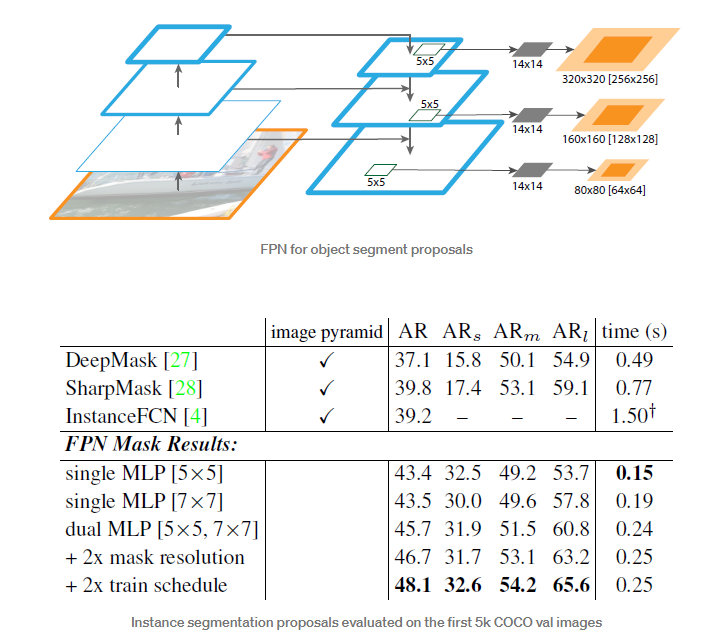
- FPNs generate segmentation proposals, following the DeepMask/SharpMask framework.
- A MLP on windows to generate dense object segments with output dimension of 14×14 masks and object scores.
- Comparing with DeepMask, SharpMask, and InstanceFCN, FPN outperforms the accuracy of these approaches by over 8.3 points AR, and nearly double the accuracy on small objects.
- Existing mask proposal methods are based on densely sampled image pyramids making them computationally expensive.
- FPN is substantially faster running at 6 to 7 FPS.
- Despite the effectiveness of ResNet and Faster R-CNN, FPN shows significant improvements over several strong baselines and competition winners.
